# Emotion detector using CNN (MobileNetV2 & ResNet)

In this project, we're using two CNN models to recognize emotions from the FER-2013 dataset. This dataset helps us understand facial expressions from images, covering seven emotions: anger, disgust, fear, happiness, neutral, sadness, and surprise. Our goal is to train a model that accurately identifies these emotions. We'll then test its effectiveness by applying it to test data, images from Google, and a video showcasing different emotional expressions, assessing its practical usefulness.

Dataset link: https://www.kaggle.com/datasets/msambare/fer2013


First we download the files from kaggle


In [ ]:
#!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0




  0%|          | 0.00/60.3M [00:00<?, ?B/s]
  2%|1         | 1.00M/60.3M [00:00<00:10, 5.80MB/s]
  5%|4         | 3.00M/60.3M [00:00<00:06, 9.50MB/s]
  8%|8         | 5.00M/60.3M [00:00<00:05, 10.5MB/s]
 12%|#1        | 7.00M/60.3M [00:00<00:05, 10.2MB/s]
 13%|#3        | 8.00M/60.3M [00:00<00:05, 10.2MB/s]
 15%|#4        | 9.00M/60.3M [00:00<00:05, 10.0MB/s]
 17%|#6        | 10.0M/60.3M [00:01<00:05, 10.0MB/s]
 18%|#8        | 11.0M/60.3M [00:01<00:05, 10.0MB/s]
 20%|#9        | 12.0M/60.3M [00:01<00:05, 9.98MB/s]
 22%|##1       | 13.0M/60.3M [00:01<00:05, 9.90MB/s]
 23%|##3       | 14.0M/60.3M [00:01<00:04, 9.91MB/s]
 25%|##4       | 15.0M/60.3M [00:01<00:04, 9.90MB/s]
 27%|##6       | 16.0M/60.3M [00:01<00:04, 9.91MB/s]
 28%|##8       | 17.0M/60.3M [00:01<00:04, 9.91MB/s]
 30%|##9       | 18.0M/60.3M [00:01<00:04, 9.89MB/s]
 31%|###1      | 19.0M/60.3M [00:02<00:04, 9.87MB/s]
 33%|###3      | 20.0M/60.3M [00:02<00:04, 9.85MB/s]
 35%|###4      | 21.0M/60.3M [00:02<00:04, 9.91MB/s]
 

In [1]:
#!unzip fer2013.zip

# Data Analysis

This will be the libraries we will use on the first part

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import keras
import os
import requests
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

from skimage.transform import resize

from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

import tensorflow.keras.layers as tfl

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array



We will create a dataframe with the number of emotions found on both out folders (test, train)

In [ ]:
train_folder = 'train'
test_folder = 'test'

emotion_counts = {}

for folder in os.listdir(train_folder):
    emotion_counts[folder] = len(os.listdir(os.path.join(train_folder, folder)))

for folder in os.listdir(test_folder):
    emotion_counts[folder] = len(os.listdir(os.path.join(test_folder, folder)))

df = pd.DataFrame(list(emotion_counts.items()), columns=['Emotion', 'Count'])

print(df)

    Emotion  Count
0     angry    958
1   disgust    111
2      fear   1024
3     happy   1774
4   neutral   1233
5       sad   1247
6  surprise    831


Now we plot a bar graph to see better the number of values we have

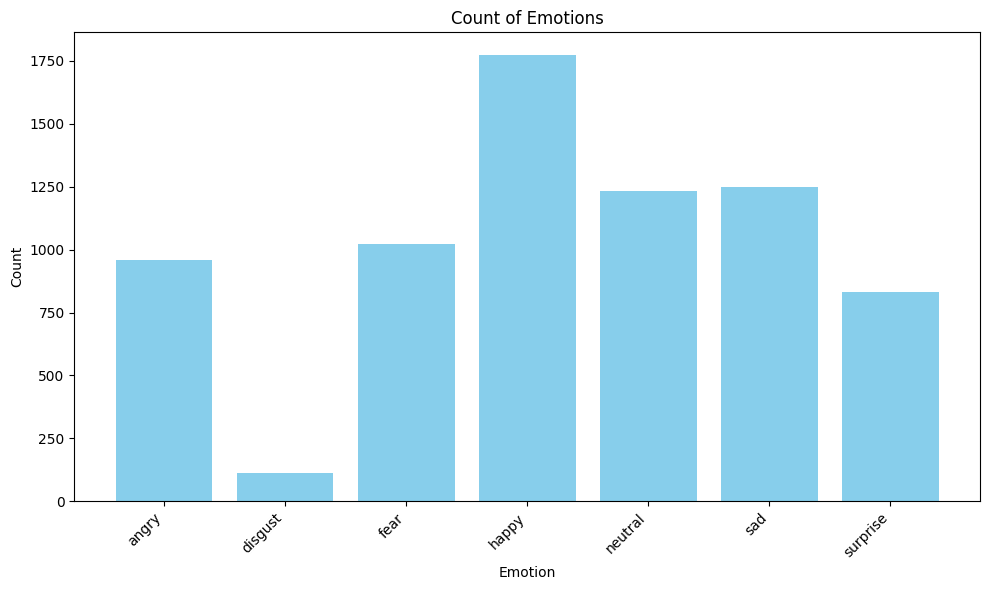

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(df['Emotion'], df['Count'], color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Count of Emotions')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


Now let's see a preview of the images we will work with

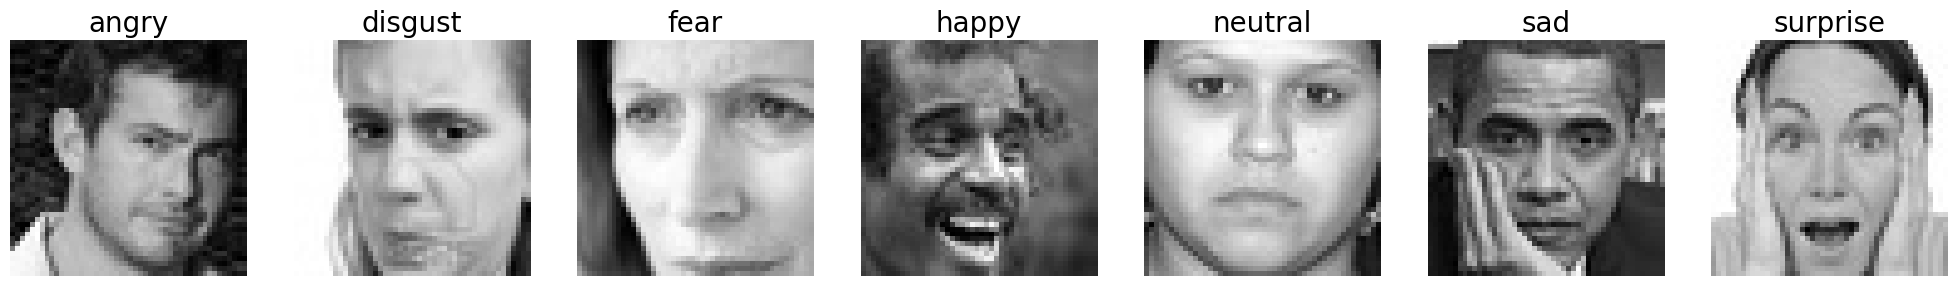

In [ ]:
# Set the style of the plot to default
plt.style.use('default')

# Define the figure size
plt.figure(figsize=(25, 8))

# Initialize a variable to keep track of the image count
image_count = 1

# Iterate over each directory in the train folder
for directory in os.listdir(train_folder):
    # Exclude any directories that start with '.' (hidden directories)
    if not directory.startswith('.'):
        # Get the list of files in the directory
        files = os.listdir(os.path.join(train_folder, directory))
        if len(files) > 1:  # Check if the directory contains at least two files
            # Load the second image from the directory
            file = files[1]
            # Create a subplot for each image
            fig = plt.subplot(1, 7, image_count)
            image_count += 1

            # Load and display the image using OpenCV
            image = cv2.imread(os.path.join(train_folder, directory, file), cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            plt.imshow(image, cmap='gray')  # Display the image in grayscale
            plt.title(directory, fontsize=20)  # Use directory name as the title
            plt.axis('off')  # Hide the axes

# Show the plot
plt.show()

Checking the matrix of our images

In [ ]:
# Load the image
image = cv2.imread("test/angry/PrivateTest_10131363.jpg")

# Check if the image is loaded successfully
if image is not None:
    # Print the array representation of the image
    print(image)
else:
    print("Image not found or could not be loaded.")

[[[ 46  46  46]
  [ 34  34  34]
  [ 26  26  26]
  ...
  [ 10  10  10]
  [ 13  13  13]
  [ 22  22  22]]

 [[ 50  50  50]
  [ 28  28  28]
  [ 21  21  21]
  ...
  [ 11  11  11]
  [ 10  10  10]
  [ 21  21  21]]

 [[ 50  50  50]
  [ 27  27  27]
  [ 15  15  15]
  ...
  [ 22  22  22]
  [ 24  24  24]
  [ 22  22  22]]

 ...

 [[208 208 208]
  [179 179 179]
  [108 108 108]
  ...
  [191 191 191]
  [205 205 205]
  [204 204 204]]

 [[212 212 212]
  [198 198 198]
  [149 149 149]
  ...
  [181 181 181]
  [200 200 200]
  [204 204 204]]

 [[208 208 208]
  [201 201 201]
  [171 171 171]
  ...
  [165 165 165]
  [180 180 180]
  [189 189 189]]]


In [ ]:
image.shape

(48, 48, 3)

# Data Augmentation

Data augmentation is a technique used to increase the diversity of a dataset by applying various transformations to the existing data samples. These transformations can include rotations, translations, flips, changes in brightness or contrast, and more. By augmenting the data, we can improve the generalization and robustness of machine learning models, especially in scenarios where the original dataset is limited in size.

This will be the shape of the images and batch size we want

In [ ]:
img_shape = 224
batch_size = 32

We apply data augmentation to our images to get better results on our model

In [ ]:
# Train data augmentation
train_da = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=50,  # Adjust brightness by shifting channels
    fill_mode='nearest'
)

# Test data preprocessing (only rescaling)
test_da = ImageDataGenerator(rescale=1.0/255.0)

then we store the images after data augmentation

In [ ]:
train_data = train_da.flow_from_directory(
    train_folder,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_da.flow_from_directory(
    test_folder,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# MobileNetV2




![Image Title](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)


This is the model we'll be using. First, we preprocess our input images using the MobileNetV2 preprocessing function. Then, we take a closer look at the model's architecture to understand its layers.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_shape,img_shape,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

We have a total of 154 layers in our model. To fine-tune its performance and potentially enhance our results, we'll freeze the last 50 layers, allowing us to experiment more extensively with the model.



In [ ]:
# Count layers
num_layers = len(base_model.layers)
print("Number of layers:", num_layers)

Number of layers: 154


Freezing the last 50 layers of MobileNetV2 while keeping the rest trainable can lead to better results compared to freezing the entire model. This approach allows for fine-tuning of task-specific features while still leveraging the pre-trained weights of the earlier layers. By focusing on adapting the higher-level representations to your dataset, you reduce the risk of overfitting and enable the model to better capture the nuances of your data. MobileNetV2 is well-suited for this strategy due to its efficient architecture, making it a popular choice for transfer learning tasks where fine-tuning is desired.

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

# Emotion Model Explanation

The `emotion_model` function defines a convolutional neural network (CNN) architecture for emotion recognition. Let's break down its components:

1. **base_model**: This is the backbone of our model, utilizing MobileNetV2 pre-trained on a large dataset. MobileNetV2 is adept at extracting meaningful features from images, which is essential for accurate emotion recognition.

2. **GlobalAveragePooling2D()**: This layer reduces the spatial dimensions of the feature maps produced by the base model to a single vector, focusing on the most important features and potentially reducing overfitting.

3. **Dense(512, activation='relu')**: A fully connected layer with 512 units and ReLU activation introduces non-linearity, allowing the model to learn complex patterns and relationships in the data, crucial for capturing nuances in facial expressions.

4. **BatchNormalization()**: This layer normalizes the activations of the previous layer, stabilizing and accelerating training, ultimately improving model convergence and robustness.

5. **Dropout(0.5)**: Dropout randomly drops 50% of the units during training, preventing overfitting by encouraging the network to learn more robust features.

6. **Dense(7, activation='softmax')**: The final fully connected layer with 7 units and softmax activation outputs the predicted probabilities for each of the 7 emotion classes. Softmax ensures that the probabilities sum up to 1, suitable for multi-class classification tasks like emotion recognition.


In [ ]:
def emotion_model():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

In [ ]:
model = emotion_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

This are metrics we want to obtain from the training of our model

In [ ]:
precision = Precision()
recall = Recall()

In [ ]:
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Callback Setup for Model Training

We're setting up callbacks to monitor and optimize the training process of our MobileNet model.

 1. **Model Checkpoint:** We create a ModelCheckpoint callback to save the best model based on validation accuracy during training. The model will be saved to the specified checkpoint path (MobileNet_Model_Checkpoint). This helps ensure that we retain the best performing model for later use.

 2. **Early Stopping:** Another callback, EarlyStopping, is employed to monitor validation accuracy. If the accuracy does not improve for a certain number of epochs (defined by the patience parameter), training will stop early. This prevents overfitting and saves computational resources.

 3. **Reduce Learning Rate on Plateau:** To further combat overfitting, we use ReduceLROnPlateau callback. It reduces the learning rate when the validation loss stops improving, potentially helping the model converge to a better solution.

Finally, we calculate steps_per_epoch and validation_steps to ensure that the model processes the entire training and validation datasets during each epoch.

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "MobileNet_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
history = model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
897/897 [==============================] - 703s 775ms/step - loss: 1.4697 - accuracy: 0.4784 - precision: 0.6188 - recall: 0.3201 - val_loss: 2.1026 - val_accuracy: 0.4268 - val_precision: 0.4530 - val_recall: 0.3862 - lr: 0.0010
Epoch 2/20
897/897 [==============================] - 495s 552ms/step - loss: 1.1708 - accuracy: 0.5648 - precision: 0.7094 - recall: 0.3961 - val_loss: 2.5146 - val_accuracy: 0.2861 - val_precision: 0.3021 - val_recall: 0.2377 - lr: 0.0010
Epoch 3/20
897/897 [==============================] - 493s 549ms/step - loss: 1.1005 - accuracy: 0.5912 - precision: 0.7239 - recall: 0.4333 - val_loss: 1.7181 - val_accuracy: 0.4248 - val_precision: 0.5022 - val_recall: 0.3419 - lr: 0.0010
Epoch 4/20
897/897 [==============================] - 497s 554ms/step - loss: 1.0580 - accuracy: 0.6056 - precision: 0.7340 - recall: 0.4627 - val_loss: 2.5623 - val_accuracy: 0.2754 - val_precision: 0.2960 - val_recall: 0.2310 - lr: 0.0010
Epoch 5/20
897/897 [================

# ResNet50V2

![Image Title](https://www.researchgate.net/publication/359153551/figure/fig1/AS:1138765179428866@1648514184733/ResNet50v2-architecture.jpg)

In [ ]:
# Load MobileNetV2 base model
res_model = tf.keras.applications.ResNet50V2(input_shape=(img_shape,img_shape,3),
                                               include_top=False,
                                               weights='imagenet')

res_model.summary()

94668760/94668760 [==============================] - 10s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                       

We check the number of layers

In [ ]:
# Count layers
num_layers = len(res_model.layers)
print("Number of layers:", num_layers)

Number of layers: 190


We will freeze the last 50 layers too

In [ ]:
# Freeze all layers in the base model
res_model.trainable = True

for layer in res_model.layers[:-50]:
    layer.trainable = False

def emotion_model():
    model = Sequential([
        res_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

r_model = emotion_model()

r_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "ResNet_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

r_model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

res_history = r_model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
897/897 [==============================] - 1222s 1s/step - loss: 1.4478 - accuracy: 0.4845 - precision: 0.6739 - recall: 0.3710 - val_loss: 1.6907 - val_accuracy: 0.5385 - val_precision: 0.7175 - val_recall: 0.3668 - lr: 0.0010
Epoch 2/20
897/897 [==============================] - 1214s 1s/step - loss: 1.2014 - accuracy: 0.5640 - precision: 0.7092 - recall: 0.3962 - val_loss: 30.1414 - val_accuracy: 0.3677 - val_precision: 0.3872 - val_recall: 0.2935 - lr: 0.0010
Epoch 3/20
897/897 [==============================] - 1218s 1s/step - loss: 1.2004 - accuracy: 0.5640 - precision: 0.7024 - recall: 0.4035 - val_loss: 1.1325 - val_accuracy: 0.5804 - val_precision: 0.7077 - val_recall: 0.4255 - lr: 0.0010
Epoch 4/20
897/897 [==============================] - 1225s 1s/step - loss: 1.0671 - accuracy: 0.6070 - precision: 0.7384 - recall: 0.4534 - val_loss: 1.0854 - val_accuracy: 0.6099 - val_precision: 0.7371 - val_recall: 0.4639 - lr: 0.0010
Epoch 5/20
897/897 [=======================

# Models Evaluation

## MobileNet evaluation

In [ ]:
def plot_curves(loss, val_loss, accuracy, val_accuracy, precision_train, recall_train, precision_val, recall_val):
    # Plot training and validation loss
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation precision
    plt.plot(precision_train, label='Training Precision')
    plt.plot(precision_val, label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.show()

    # Plot training and validation recall
    plt.plot(recall_train, label='Training Recall')
    plt.plot(recall_val, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.show()


In [ ]:
model_Score = model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(model_Score[0]))
print("Test Accuracy: {:.2f}%".format(model_Score[1] * 100))

225/225 [==============================] - 60s 267ms/step - loss: 0.9468 - accuracy: 0.6775 - precision: 0.7332 - recall: 0.6241
Test Loss:     0.94682
Test Accuracy: 67.75%


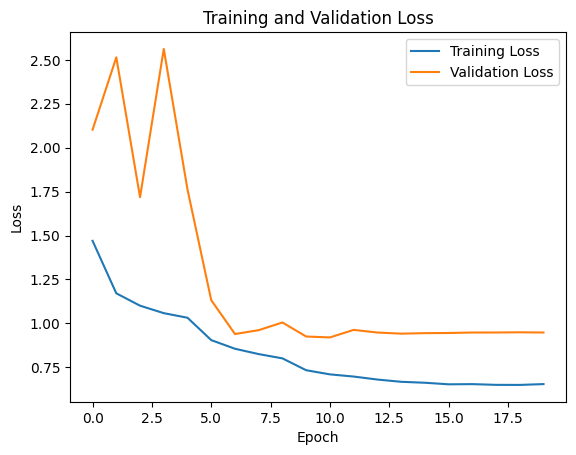

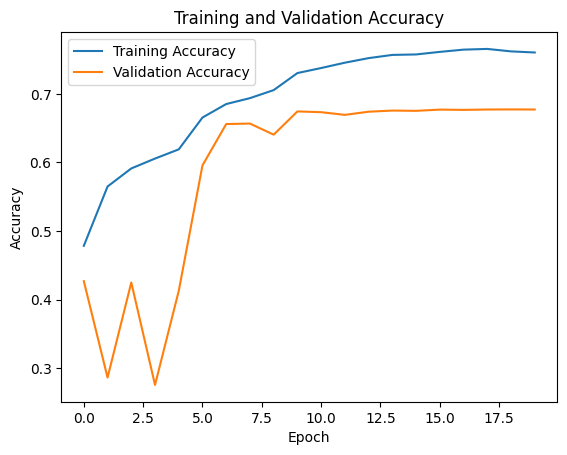

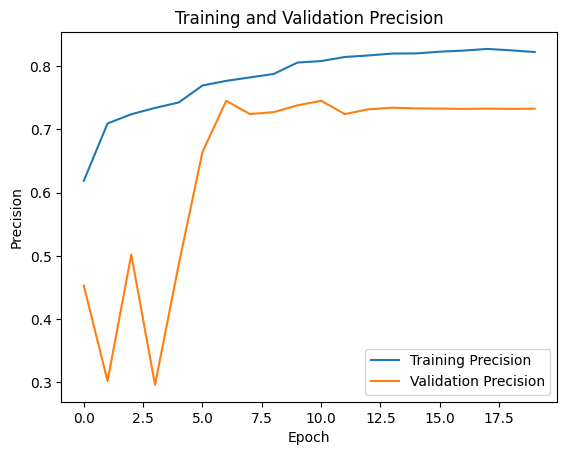

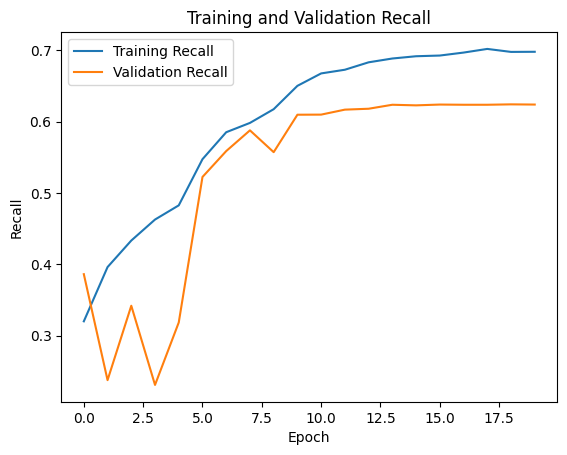

In [ ]:
# Extract metrics from the history object
metrics = {
    "loss": history.history["loss"],
    "val_loss": history.history["val_loss"],
    "accuracy": history.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"],
    "precision_train": history.history["precision"],
    "recall_train": history.history["recall"],
    "precision_val": history.history["val_precision"],
    "recall_val": history.history["val_recall"]
}

# Call the plot_curves function with the extracted metrics
plot_curves(**metrics)

In [ ]:
predictions = model.predict(test_data)

# Choosing highest probalbilty class in every prediction
predictions = np.argmax(predictions, axis=1)

225/225 [==============================] - 61s 269ms/step


In [ ]:
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))


******** Final Metrics ********
Final Accuracy        : 76.04%
Final Precision       : 82.23%
Final Recall          : 69.77%
Final Validation Loss : 0.9478
Final F1 Score        : 0.755


## ResNet evaluation

In [ ]:
r_model_Score = r_model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(r_model_Score[0]))
print("Test Accuracy: {:.2f}%".format(r_model_Score[1] * 100))

225/225 [==============================] - 137s 610ms/step - loss: 0.9163 - accuracy: 0.6773 - precision: 0.7338 - recall: 0.6265
Test Loss:     0.91628
Test Accuracy: 67.73%


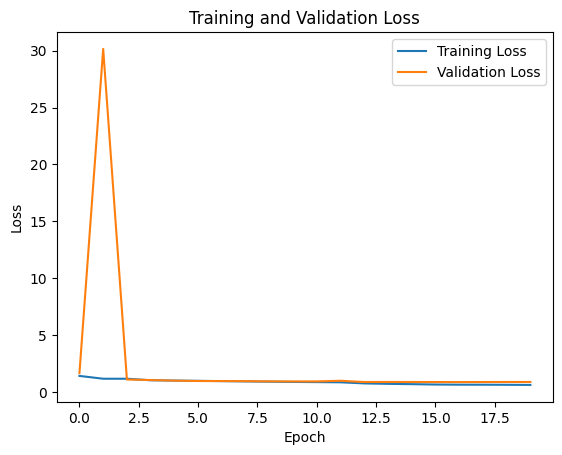

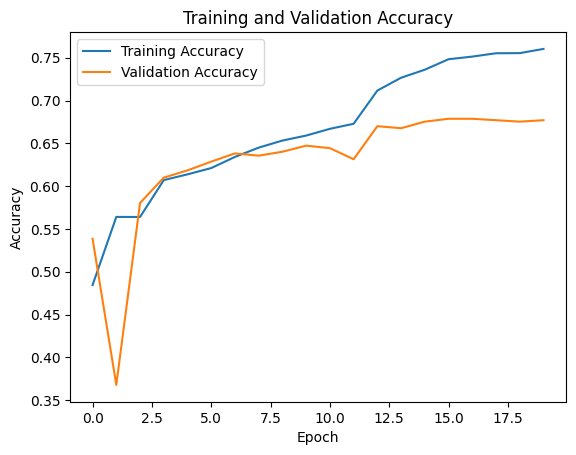

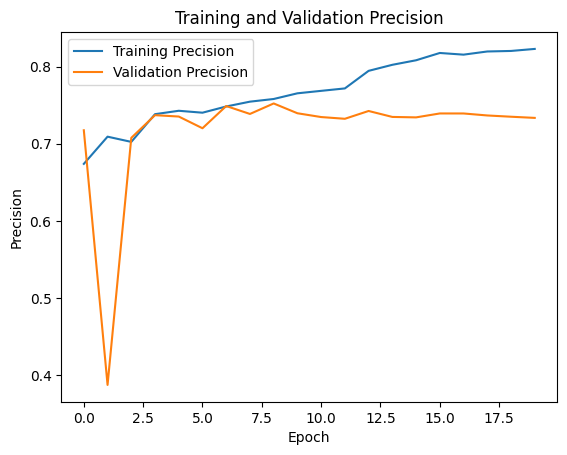

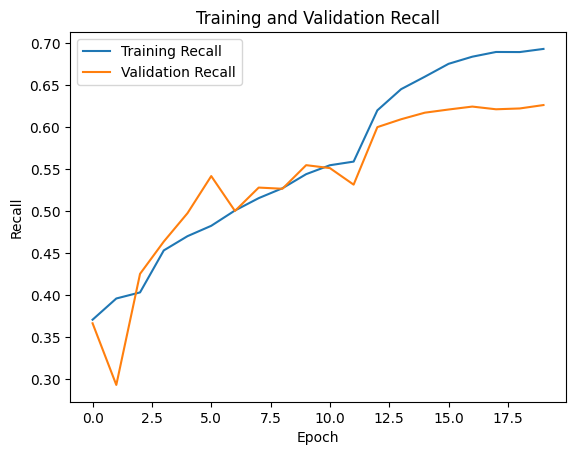

In [ ]:
# Extract metrics from the history object
metrics = {
    "loss": res_history.history["loss"],
    "val_loss": res_history.history["val_loss"],
    "accuracy": res_history.history["accuracy"],
    "val_accuracy": res_history.history["val_accuracy"],
    "precision_train": res_history.history["precision"],
    "recall_train": res_history.history["recall"],
    "precision_val": res_history.history["val_precision"],
    "recall_val": res_history.history["val_recall"]
}

# Call the plot_curves function with the extracted metrics
plot_curves(**metrics)

In [ ]:
r_predictions = r_model.predict(test_data)

# Choosing highest probalbilty class in every prediction
r_predictions = np.argmax(r_predictions, axis=1)

225/225 [==============================] - 142s 628ms/step


In [ ]:
final_accuracy = res_history.history['accuracy'][-1]
final_precision = res_history.history['precision'][-1]
final_recall = res_history.history['recall'][-1]
final_val_loss = res_history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))


******** Final Metrics ********
Final Accuracy        : 76.03%
Final Precision       : 82.30%
Final Recall          : 69.28%
Final Validation Loss : 0.9170
Final F1 Score        : 0.752


# Best Model Testing on external images and videos

We will visualize the result we got on the test data

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_folder,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


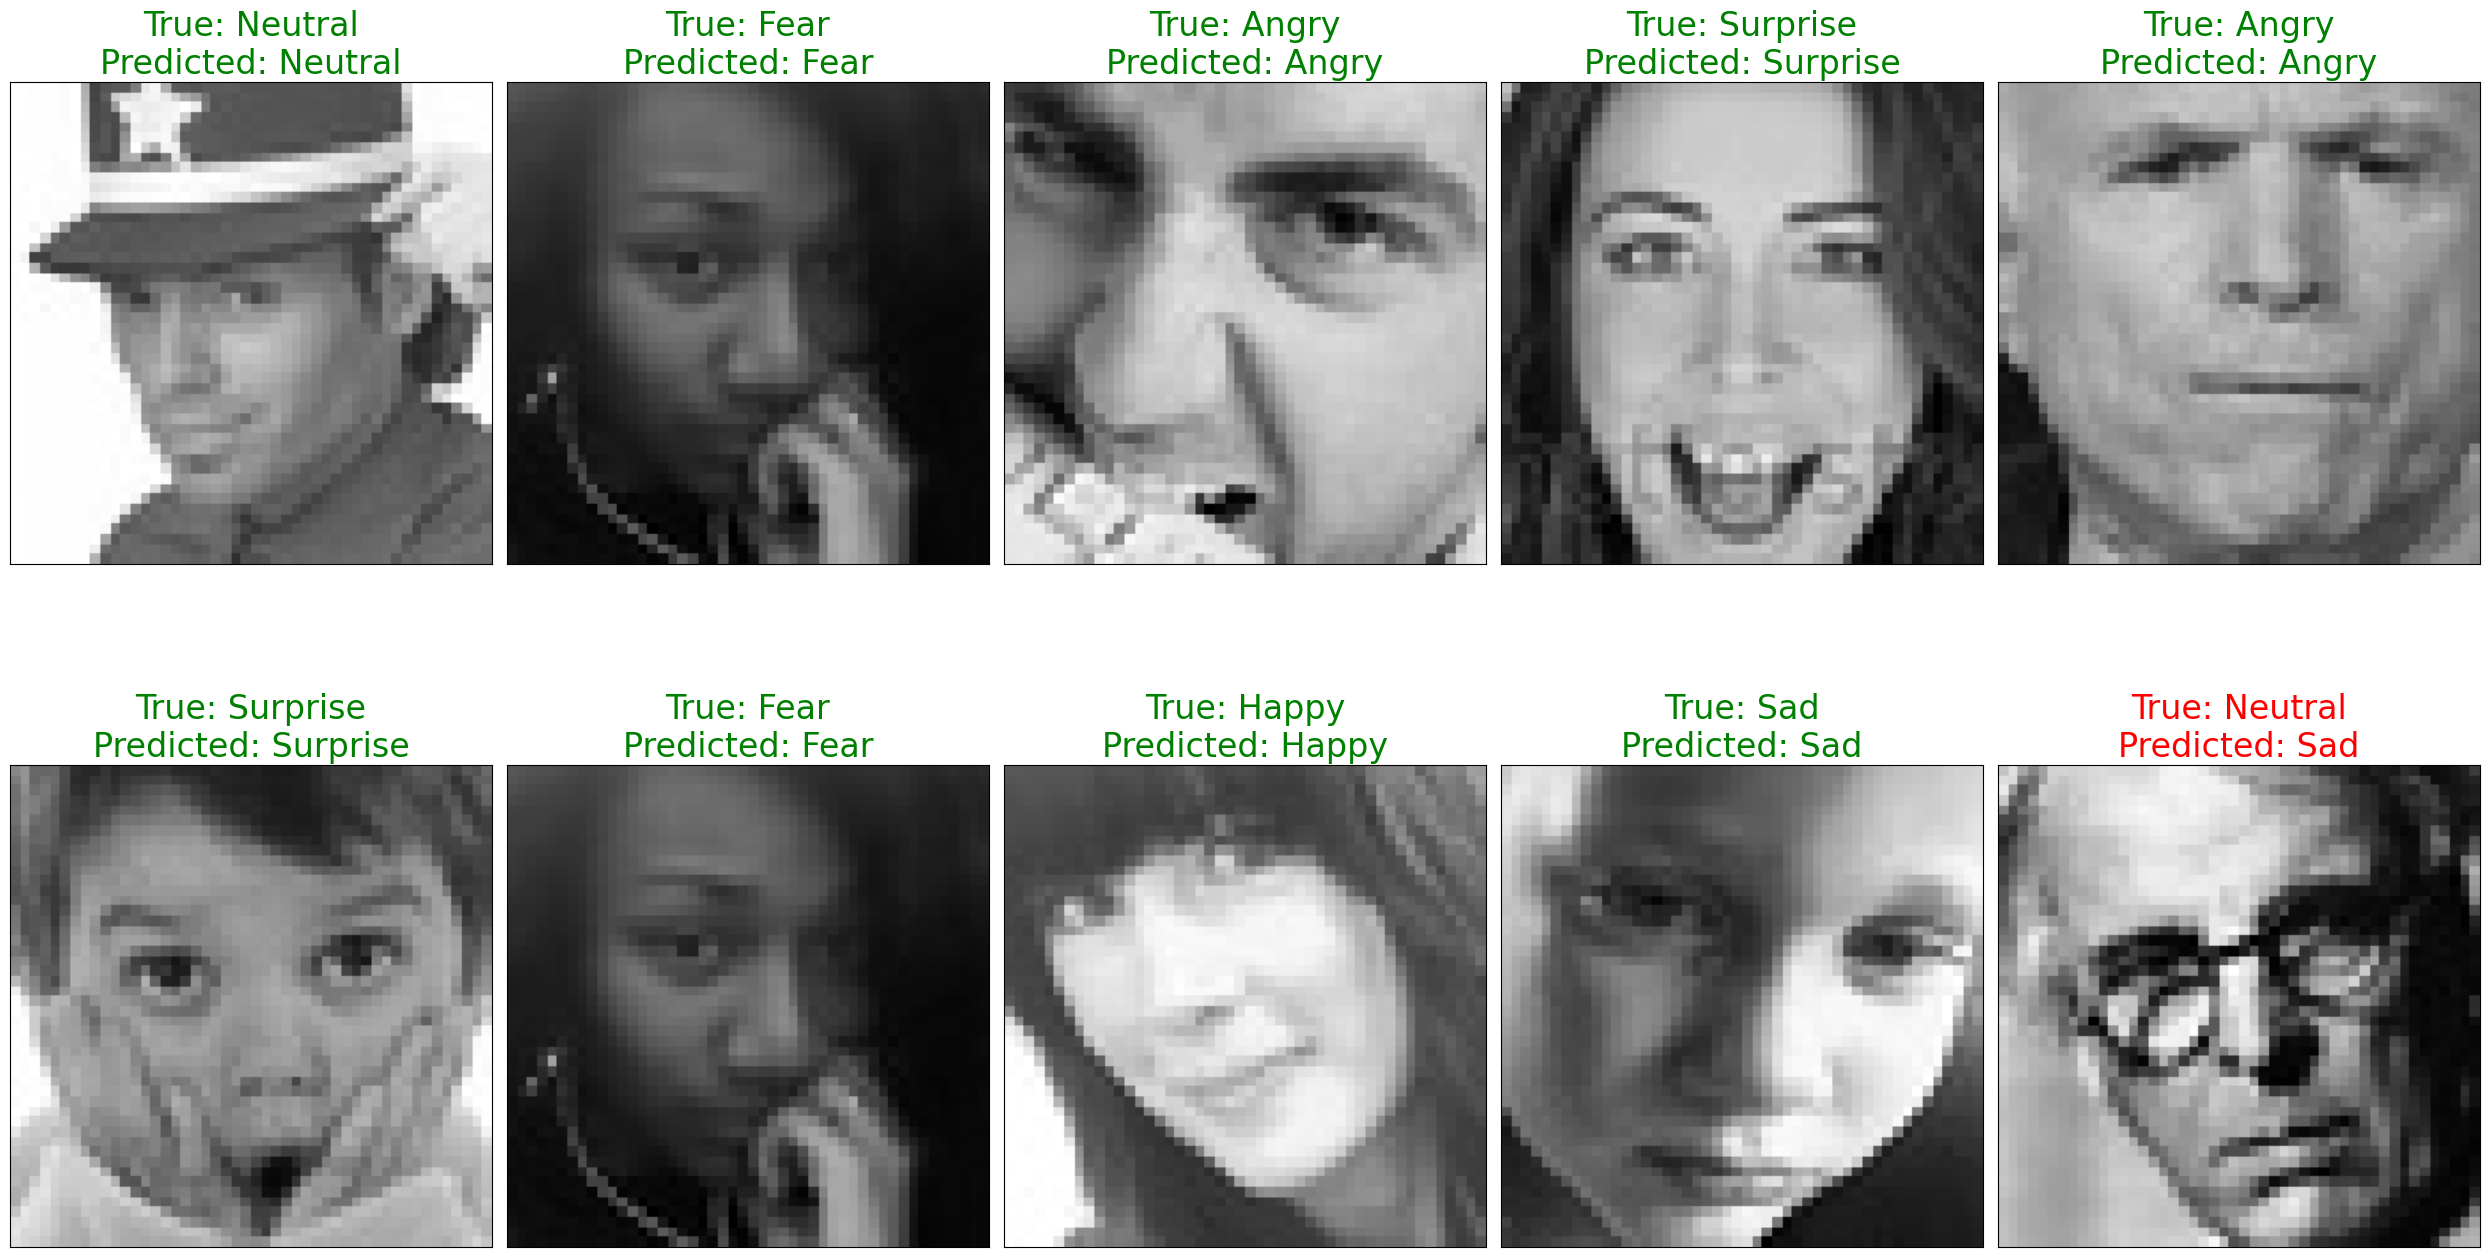

In [ ]:
class_indices = test_data.class_indices
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]

# Assuming test_generator contains your image data
# batch_size is the size of the batch
# Emotion_Classes is a list containing emotion classes

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (img_shape,img_shape), anti_aliasing=True)

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(model.predict(Random_Img_resized.reshape(1, img_shape, img_shape, 3), verbose=0))

    ax.imshow(Random_Img_resized)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


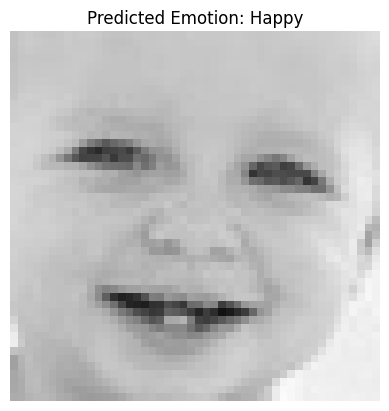

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = 'test/happy/PrivateTest_1140198.jpg'  # Replace 'path_to_your_image.jpg' with the actual path

# Load the image with the desired target size
img = image.load_img(img_path, target_size=(img_shape[0], img_shape[1]))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the expected input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (optional, depending on how your model was trained)
# For example, you may need to rescale the pixel values to the range [0, 1]
img_array = img_array / 255.0  # Assuming the model was trained with pixel values in the range [0, 255]

# Make predictions using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the corresponding emotion class label
predicted_emotion = Emotion_Classes[predicted_class_index]

# Display the image and predicted emotion
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

Now let's test it on images found on google

In [ ]:
# Function to download an image from a URL
def download_image(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception if request fails
    img_data = response.content
    with open(filename, 'wb') as f:
        f.write(img_data)

# Example usage
url = "https://www.shutterstock.com/image-photo/man-having-headache-isolated-over-260nw-84183583.jpg"
filename = "depressed_friend_image.jpg"  # Filename to save the image
download_image(url, filename)

1/1 [==============================] - 0s 47ms/step


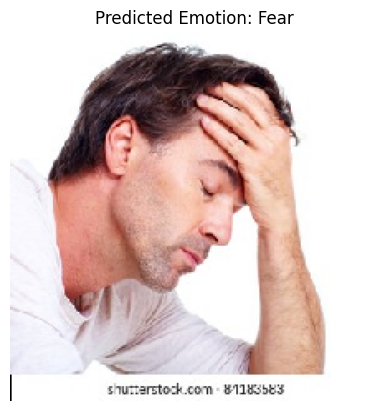

In [ ]:
# Load the external image
img_path = 'depressed_friend_image.jpg'  # Replace 'path_to_your_image.jpg' with the actual path
img = image.load_img(img_path, target_size=(img_shape,img_shape))  # Assuming your model expects input images of size (48, 48)

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the expected input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (optional, depending on how your model was trained)
# For example, you may need to rescale the pixel values to the range [0, 1]
img_array = img_array / 255.0  # Assuming the model was trained with pixel values in the range [0, 255]

# Make predictions using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the corresponding emotion class label
predicted_emotion = Emotion_Classes[predicted_class_index]

# Display the image and predicted emotion
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

In [ ]:
def download_image(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception if request fails
    img_data = response.content
    with open(filename, 'wb') as f:
        f.write(img_data)

# Example usage
url = "https://img.freepik.com/free-photo/portrait-scared-man-pink_155003-31078.jpg"
filename = "scared_man_image.jpg"  # Filename to save the image
download_image(url, filename)

1/1 [==============================] - 0s 31ms/step


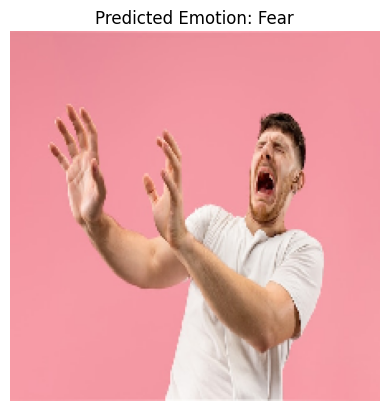

In [ ]:
# Load the external image
img_path = 'scared_man_image.jpg'  # Replace 'path_to_your_image.jpg' with the actual path
img = image.load_img(img_path, target_size=(img_shape,img_shape))  # Assuming your model expects input images of size (48, 48)

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the expected input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (optional, depending on how your model was trained)
# For example, you may need to rescale the pixel values to the range [0, 1]
img_array = img_array / 255.0  # Assuming the model was trained with pixel values in the range [0, 255]

# Make predictions using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the corresponding emotion class label
predicted_emotion = Emotion_Classes[predicted_class_index]

# Display the image and predicted emotion
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

Finally we will test it on a video


*   Emotions Stock Footage - Emotions Free Stock Videos - Emotions No
  Elemento de la lista Copyright Videos

  From PexBell


Video Link: https://www.youtube.com/watch?v=pnFj9w3FGc8

In [ ]:
#!pip install pytube

                                              0.0/57.6 kB ? eta -:--:--
     ---------------------                    30.7/57.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 751.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from pytube import YouTube
import cv2
from tensorflow.keras.models import load_model

In [ ]:
# Function to download a portion of a YouTube video
def download_video(video_url, output_filename, duration=60):
    yt = YouTube(video_url)
    stream = yt.streams.filter(progressive=True).first()
    stream.download(output_path="./", filename=output_filename)

# Example usage
video_url = "https://www.youtube.com/watch?v=pnFj9w3FGc8"
output_filename = "first_1_minute_video.mp4"  # Output filename for the downloaded video
download_video(video_url, output_filename)

1/1 [==============================] - 0s 36ms/step


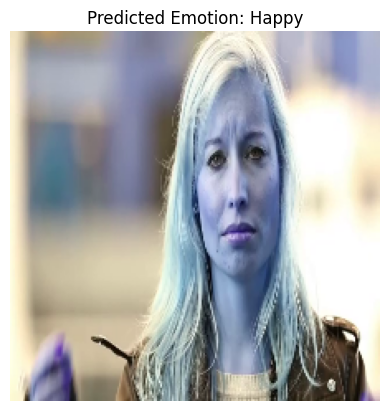

In [ ]:
def preprocess_frame(frame):
    # Example: Resize the frame to a specific size (e.g., 224x224) and normalize pixel values
    processed_frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
    processed_frame = processed_frame.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    return processed_frame

# Load the video
video_capture = cv2.VideoCapture('first_1_minute_video.mp4')

# Extract the first frame
_, frame = video_capture.read()

# Preprocess the frame (resize, normalize, etc.)
processed_frame = preprocess_frame(frame)  # You need to define preprocess_frame() function

# Make prediction on the preprocessed frame
prediction = model.predict(np.expand_dims(processed_frame, axis=0))

# Get the predicted class label (assuming classification task)
predicted_class = np.argmax(prediction)

# Display the image and predicted emotion
plt.imshow(processed_frame)
plt.title(f"Predicted Emotion: {predicted_emotion}")  # Assuming you define predicted_emotion
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 51ms/step


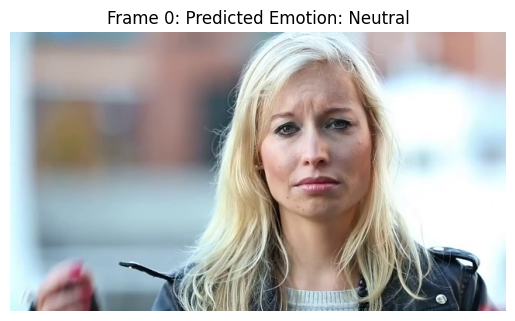

1/1 [==============================] - 0s 49ms/step


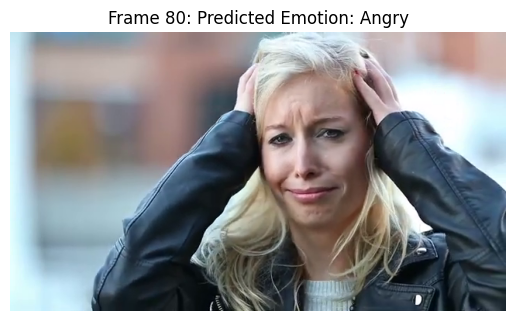

1/1 [==============================] - 0s 63ms/step


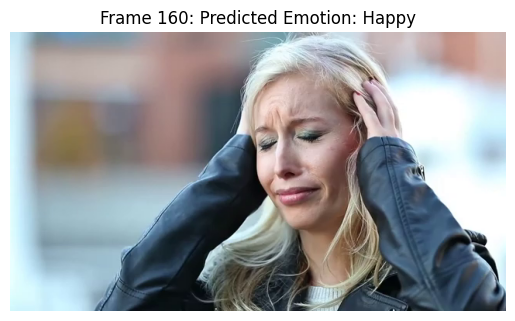

1/1 [==============================] - 0s 64ms/step


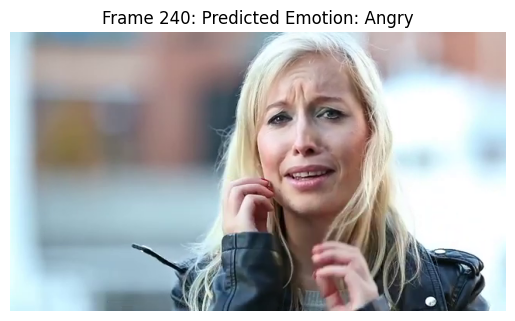

1/1 [==============================] - 0s 63ms/step


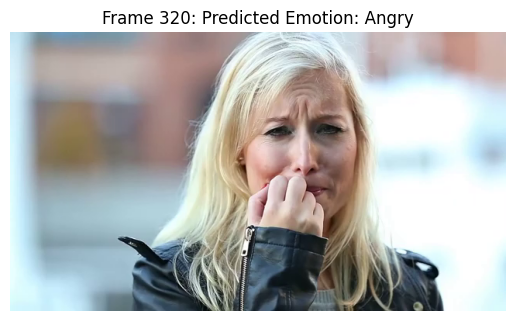

1/1 [==============================] - 0s 60ms/step


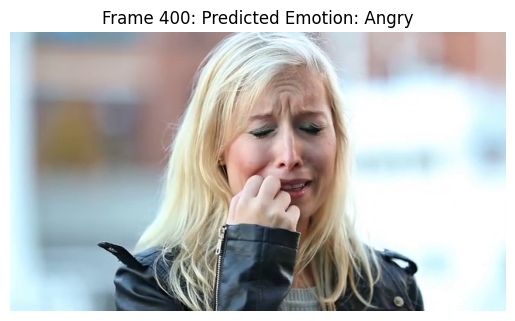

1/1 [==============================] - 0s 48ms/step


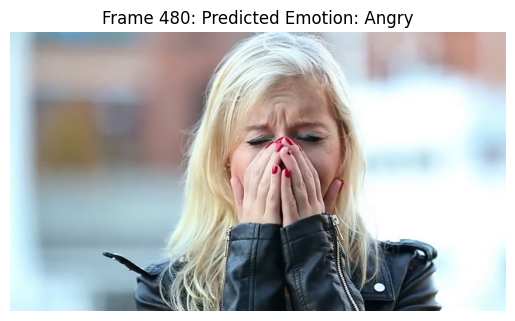

1/1 [==============================] - 0s 55ms/step


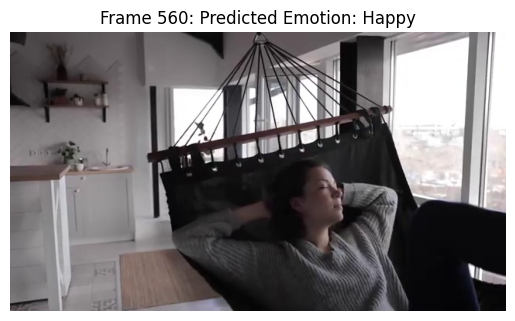

1/1 [==============================] - 0s 47ms/step


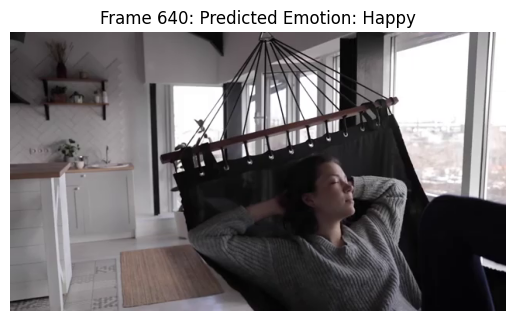

1/1 [==============================] - 0s 48ms/step


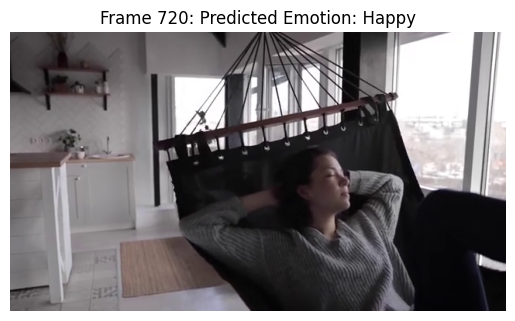

1/1 [==============================] - 0s 47ms/step


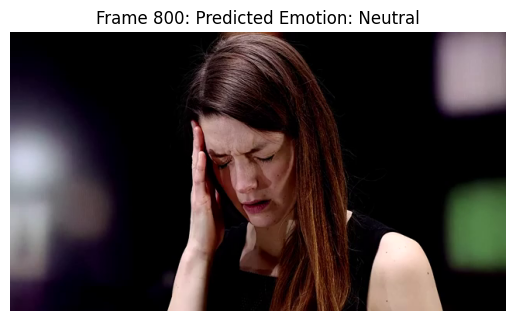

1/1 [==============================] - 0s 41ms/step


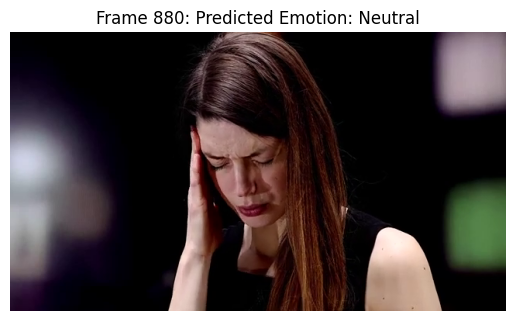

1/1 [==============================] - 0s 54ms/step


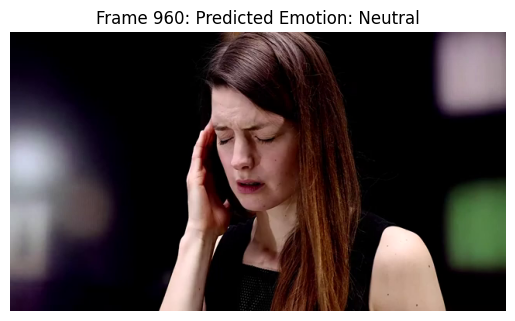

1/1 [==============================] - 0s 47ms/step


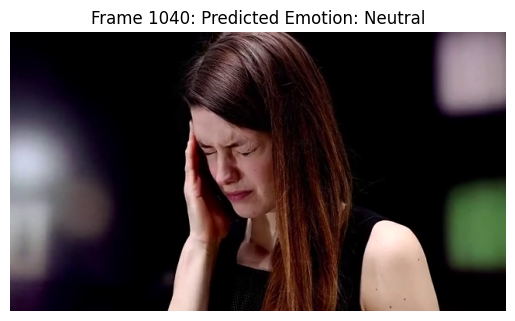

1/1 [==============================] - 0s 52ms/step


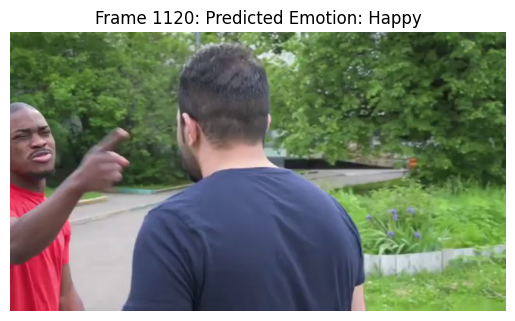

1/1 [==============================] - 0s 48ms/step


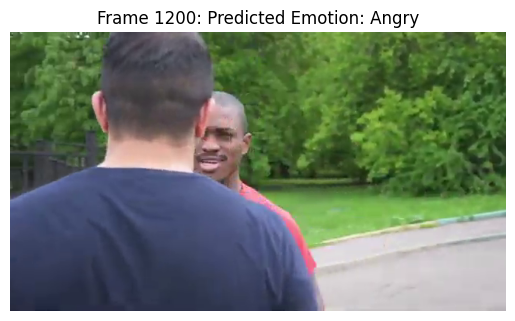

1/1 [==============================] - 0s 51ms/step


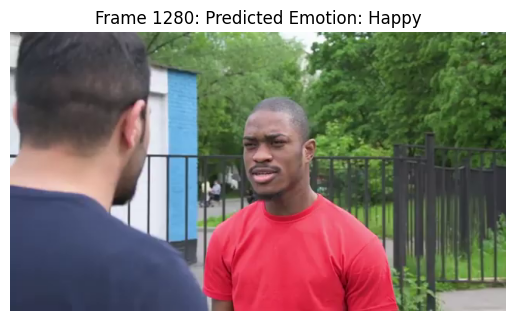

1/1 [==============================] - 0s 51ms/step


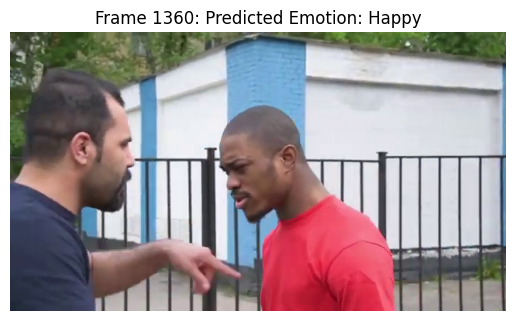

1/1 [==============================] - 0s 50ms/step


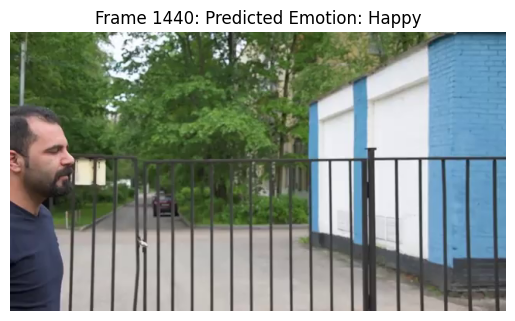

1/1 [==============================] - 0s 56ms/step


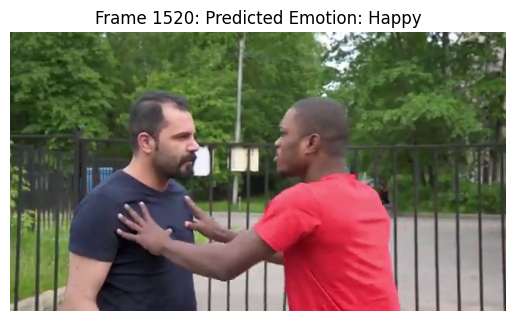

In [ ]:
# Load the video
video_capture = cv2.VideoCapture('first_1_minute_video.mp4')

# Get the total number of frames in the video
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Define the frame indices to be extracted
frame_indices = range(0, total_frames, 80)[:20]

# Iterate through the selected frames
for frame_index in frame_indices:
    # Set the frame position to read
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the frame
    ret, frame = video_capture.read()

    # Check if frame is successfully read
    if ret:
        # Preprocess the frame
        processed_frame = preprocess_frame(frame)

        # Make prediction on the preprocessed frame
        prediction = model.predict(np.expand_dims(processed_frame, axis=0))

        # Get the predicted class label (assuming classification task)
        predicted_class = np.argmax(prediction)

        # Here, you should have some way to map predicted class to emotion
        # For example, if predicted_class is an index, you can have a list of emotions
        emotions = ["Happy", "Sad", "Angry", "Neutral"]  # Example emotions
        predicted_emotion = emotions[predicted_class]  # Assuming you have such mapping

        # Display the frame and predicted emotion
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_index}: Predicted Emotion: {predicted_emotion}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Failed to read frame {frame_index} from the video.")

# Release the video capture object
video_capture.release()

#Conclusion

This CNN project focused on developing emotion recognition models using MobileNetV2 and ResNet50V2 architectures trained on the FER2023 dataset. While MobileNetV2 exhibited slightly superior performance compared to ResNet50V2 on the test dataset, the difference was marginal. However, when tested on external data sources such as images from Google or a video, MobileNetV2 encountered challenges in accurately predicting emotions.

These difficulties likely stem from disparities between the training data and real-world scenarios, emphasizing the necessity of data diversity and robustness testing. To address these issues and enhance overall performance, future efforts will involve fine-tuning the model and optimizing parameters.

Despite these hurdles, this project provides valuable insights into the application of CNNs for emotion recognition. It underscores the importance of considering real-world applications and the iterative refinement of models to achieve optimal results. By documenting our methodologies and lessons learned, we contribute to advancing the understanding of CNN approaches and their practical implications in fields such as emotion recognition and beyond.